# Building The Model

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive
import arviz as az
from jax import random
import jax.numpy as jnp

In [14]:
rng_key = random.key(0)

In [15]:
DATA_PATH = "../data/msn_arrivals.csv"
msn_arrivals = pd.read_csv(DATA_PATH)

As an example, below is a plot of the distribution of arrival delays

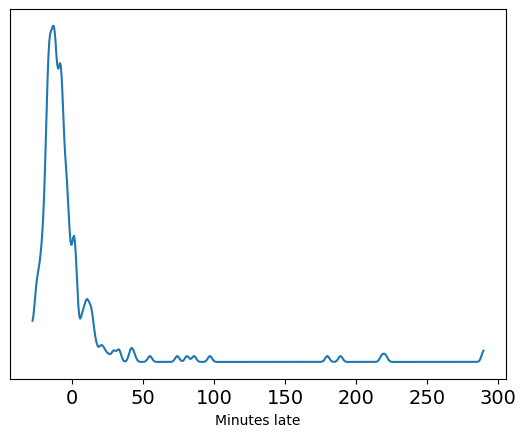

In [16]:
fig, ax = plt.subplots()

az.plot_kde(msn_arrivals.values, ax=ax)
ax.set_yticks([])
ax.set_xlabel("Minutes late");

We can see that the delay is continous variable that is skewed. We have a few distributions that we could use:

1. Normal: it is symmetrical and inconsistent with the observed skewness
2. Skew-Normal
3. Gumbel: it is used to model the distribution of the maximum (or the minimum) of a number of samples

We will compare the Normal and Gumbel distributions

## Choosing Priors

We can see that flight arrivals can be early or late (negative or positive respectively) but exhibit some bounds. It is unlikely that a flight would arrive more than 3 hours late, be more than 3 hours early.

Based on that we can can set priors for $\mu$ and scale. 

We choose the normal distrubtion for the \mu centered at zero with standard deviation of 40 (delay can by 0 $\pm$ 120) and the scale to follow a Half-StudentT distribution 


**Model 1**:

$$
\begin{aligned}
\mu &\sim \mathcal{N}(\mu=0, \sigma=40) \\
\sigma &\sim \mathcal{HT}(\nu=5, \mu=0, \sigma=60)\\
y &\sim \mathcal{N}(\mu, \sigma)
\end{aligned}
$$

**Model 2**:

$$
\begin{aligned}
\mu &\sim \mathcal{N}(\mu=0, \sigma=40) \\
\beta &\sim \mathcal{HT}(\nu=5, \mu=0, \sigma=60)\\
y &\sim \text{Gumbel}(\mu, \beta)\\
\end{aligned}
$$

let's simulate some data to see if our priors are reasonable

In [17]:
class HalfStudentT(dist.Distribution):
    arg_constraints = {
        "df": dist.constraints.positive,
        "scale": dist.constraints.positive,
    }
    support = dist.constraints.positive
    reparametrized_params = ["df", "scale"]
    pytree_data_fields = ("df", "scale", "_chi2")

    def __init__(self, df, scale=1.0, *, validate_args=None):
        from jax import lax
        self._studentT = dist.StudentT(df, 0.0, scale)
        batch_shape = lax.broadcast_shapes(
            jnp.shape(df), jnp.shape(scale)
        )
        self.df, self.scale = numpyro.distributions.util.promote_shapes(
            df, scale, shape=batch_shape
        )
        df = jnp.broadcast_to(df, batch_shape)
        self._chi2 = dist.Chi2(df)
        super(HalfStudentT, self).__init__(batch_shape, validate_args=validate_args)

    def sample(self, key, sample_shape=()):
        return jnp.abs(self._studentT.sample(key, sample_shape))
    
    @numpyro.distributions.util.validate_sample
    def log_prob(self, value):
        return self._studentT.log_prob(value) + jnp.log(2)

In [31]:
def model1(delay_obs=None):
    mu = numpyro.sample("mu", dist.Normal(0, 40))
    sigma = numpyro.sample("sigma", HalfStudentT(5, 60))
    numpyro.sample("delay", dist.Normal(mu, sigma), obs=delay_obs)

In [34]:
def model2(delay_obs=None):
    mu = numpyro.sample("mu", dist.Normal(0, 40))
    beta = numpyro.sample("beta", HalfStudentT(5, 60))
    numpyro.sample("delay", dist.Gumbel(mu, beta), obs=delay_obs)

In [35]:
def sample(model, rng_key_):
    rng_key_, rng_key__ = random.split(rng_key_)
    kernel = NUTS(model)
    sampler = MCMC(kernel, num_chains=4, num_warmup=500, num_samples=1000)
    sampler.run(rng_key_)
    prior_predictive_samples = Predictive(model, num_samples=1000)(rng_key_)
    return az.from_numpyro(sampler, prior=prior_predictive_samples)

In [36]:
rng_key, rng_key_ = random.split(rng_key)
inf_data_model1 = sample(model1, rng_key_)

C:\Users\Mostafa\AppData\Local\Temp\ipykernel_1456\1565031027.py:4: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = MCMC(kernel, num_chains=4, num_warmup=500, num_samples=1000)
sample: 100%|██████████| 1500/1500 [00:00<00:00, 3100.62it/s, 7 steps of size 3.86e-01. acc. prob=0.65] 


In [37]:
rng_key, rng_key_ = random.split(rng_key)
inf_data_model2 = sample(model2, rng_key_)

C:\Users\Mostafa\AppData\Local\Temp\ipykernel_1456\1565031027.py:4: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = MCMC(kernel, num_chains=4, num_warmup=500, num_samples=1000)
sample: 100%|██████████| 1500/1500 [00:00<00:00, 3218.81it/s, 7 steps of size 3.19e-01. acc. prob=0.69] 


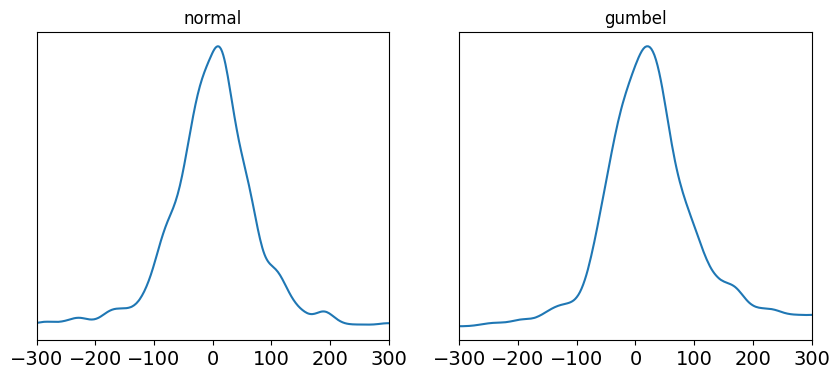

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

prior_predictives = {"normal": inf_data_model1.prior['delay'].data, "gumbel": inf_data_model2.prior['delay'].data }

for i, (label, prior_predictive) in enumerate(prior_predictives.items()):
    
    data = prior_predictive.flatten()
    az.plot_dist(data, ax=axes[i])
    axes[i].set_yticks([])
    axes[i].set_xlim(-300, 300)
    axes[i].set_title(label)

The prior predictive check shows that both models are reasonable for our assumptions